In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.2.1+cu121'

### 1. Creating non-linear data (red and blue circles)

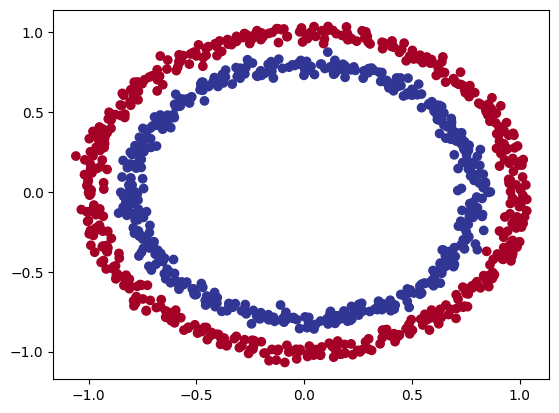

In [2]:
# Make and plot data
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({'X1': X[:, 0],
                        'X2': X[:, 1],
                        'label': y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Convert data to tensors and then to train and test splits
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 2. Building a model with non-linearity

In [5]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
# Build a model with non-linear activation functions
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModel().to(device)
model_1

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [7]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),
                            lr=0.1)



In [8]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Training a model with non-linearity

In [9]:
len(X_test), len(y_test)

(200, 200)

In [10]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch}, Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Epoch: 0, Loss: 0.6963, Acc: 50.00% | Test Loss: 0.6975, Test Acc: 50.00%
Epoch: 100, Loss: 0.6900, Acc: 51.50% | Test Loss: 0.6917, Test Acc: 50.50%
Epoch: 200, Loss: 0.6875, Acc: 66.25% | Test Loss: 0.6894, Test Acc: 66.50%
Epoch: 300, Loss: 0.6842, Acc: 68.00% | Test Loss: 0.6864, Test Acc: 67.00%
Epoch: 400, Loss: 0.6795, Acc: 68.25% | Test Loss: 0.6820, Test Acc: 66.00%
Epoch: 500, Loss: 0.6726, Acc: 70.62% | Test Loss: 0.6758, Test Acc: 70.50%
Epoch: 600, Loss: 0.6616, Acc: 73.38% | Test Loss: 0.6661, Test Acc: 71.50%
Epoch: 700, Loss: 0.6429, Acc: 79.25% | Test Loss: 0.6501, Test Acc: 77.00%
Epoch: 800, Loss: 0.6074, Acc: 86.00% | Test Loss: 0.6212, Test Acc: 84.00%
Epoch: 900, Loss: 0.5412, Acc: 95.00% | Test Loss: 0.5655, Test Acc: 93.00%


### 4. Evaluating a model trained with non-linear activation functions

In [11]:
# Make predictions
model_1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [12]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/Claudiu-Mihael-Terenche/Machine-Learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

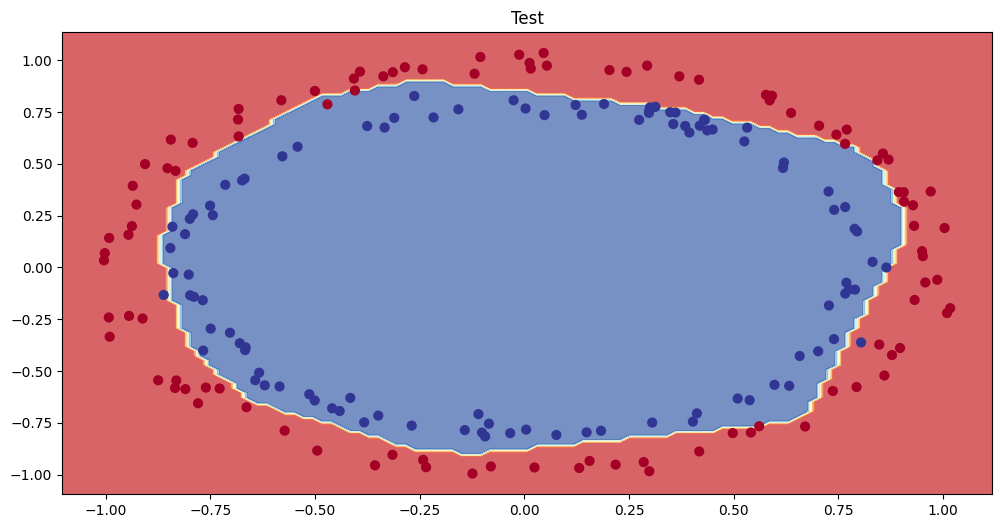

In [13]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

In [14]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

In [15]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

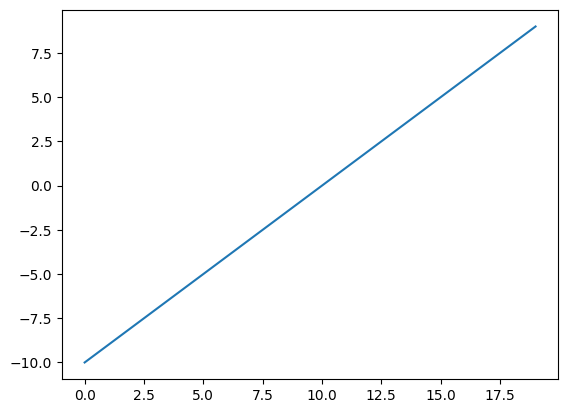

In [16]:
# Visualize the tensor
plt.plot(A);

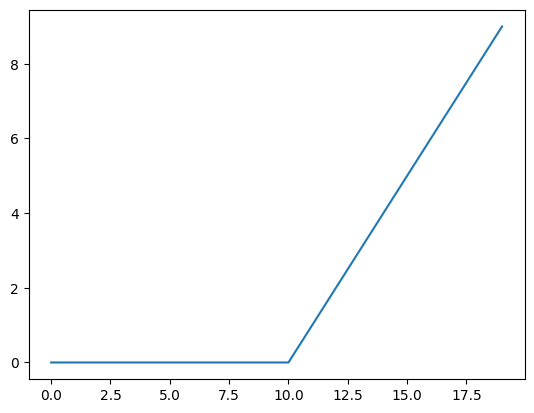

In [17]:
plt.plot(torch.relu(A));

In [18]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

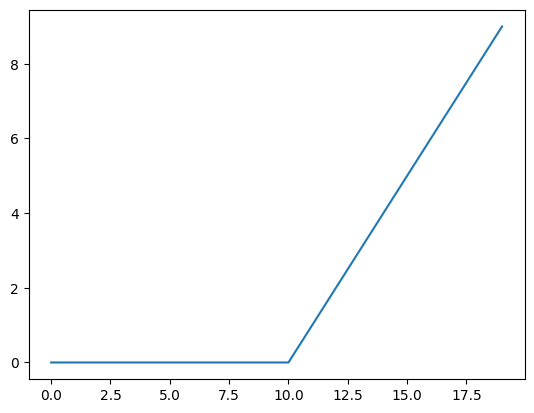

In [19]:
# Plot ReLU activation function
plt.plot(relu(A))

In [20]:
# Sigmoid = https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

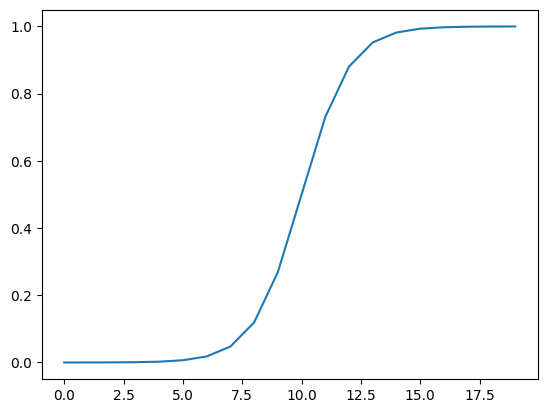

In [21]:
plt.plot(torch.sigmoid(A));

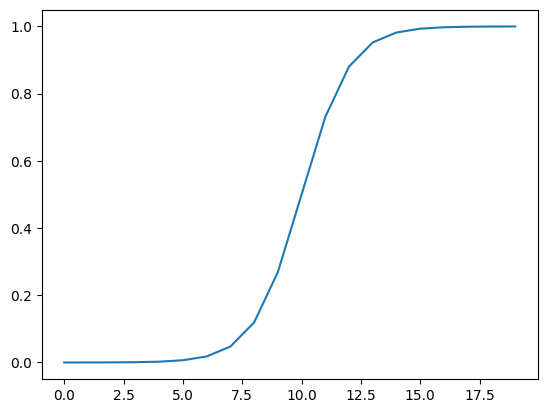

In [22]:
plt.plot(sigmoid(A));